# DS 504 Big data analytics project2



In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os, random, sys

JoinResPath = "./data/JoinResults/"
Ilist = [i for i in os.listdir(JoinResPath) if not i.startswith(".")]

def readJR(Id=None,LEAST = 100):
    #least: threshold for number of trajectory points
    Iid = (str(Id) if type(Id)==int else Id) if Id else random.choice(Ilist)
    with open(JoinResPath+Iid,"rb") as f:
        res = []
        for i in f:
            res.append(i.strip().split(","))
    df = pd.DataFrame(res[1:])
    if not Id and not len(df)>LEAST:
        return readJR(None,LEAST)
    df[1],df[2], df[3] = pd.to_datetime(df[1]), df[2].astype(float), df[3].astype(float) 
    return (int(res[0][0]),float(res[0][1]),float(res[0][2])),df.sort_values([0,1])
    
def plotJR(c,df,**kargs):
    plt.scatter(df[2],df[3],**kargs)
    plt.scatter(float(c[1]),float(c[2]),color="r",s=30)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))

def spliTraj(df,threshold):
    curr, last = None, None
    split=[0]
    for i in xrange(df.shape[0]):
        if type(curr)!=type(None):
            last=curr
        curr = df.iloc[i,1]
        if type(last)!=type(None):
            if curr-last>threshold:
                split.append(i)
    split.append(i+1)
    #return split
    ret = []
    for i in xrange(1,len(split)):
        splited=df.iloc[split[i-1]:split[i],:]
        ret.append(splited)
    return ret
    
def plotJR_line(c,df,**kargs):
    plt.scatter(c[1],c[2],color="r",s=30)
    for t in set(points.ix[:,0]):    
        p = df.ix[df.ix[:,0]==t,:].sort_values(by=1)
        if len(p)>1:plt.plot(p.ix[:,2],p.ix[:,3],**kargs)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))
    
def timeRange(df,time,**rng):
    mask = df.ix[:,1]<time+pd.DateOffset(**rng)
    mask &= df.ix[:,1]>=time
    return df.ix[mask,:]

(4404, 22.5512118, 114.0547136) (22.549216999999999, 114.052719, 22.553166999999998, 114.056709)
http://maps.google.com/maps?z=12&t=k&q=loc:22.551212+114.054714


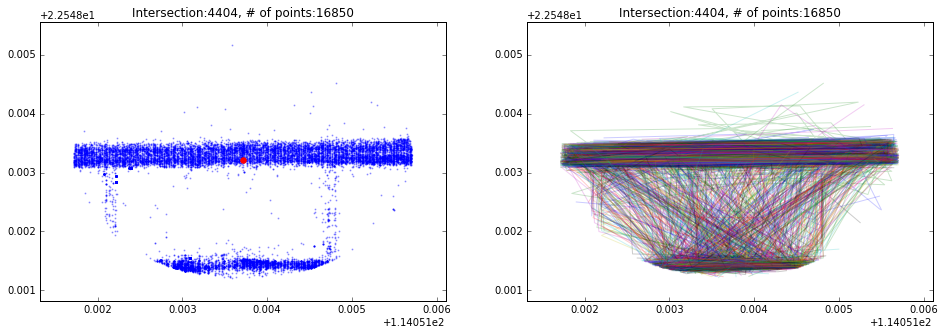

In [25]:
#3420,2076,3712,1138,4133,3693，4951
center,points = readJR(LEAST=30)
print(center[0],center[2],center[1]),(points[3].min(),points[2].min(),points[3].max(),points[2].max())
print "http://maps.google.com/maps?z=12&t=k&q=loc:%f+%f" % (center[2],center[1])
fig = plt.figure(figsize=(16,5))
fig.add_subplot(121)
plotJR(center,points,s=1,color="b",alpha=.3)
fig.add_subplot(122)
plotJR_line(center,points,alpha=.2)
plt.show()

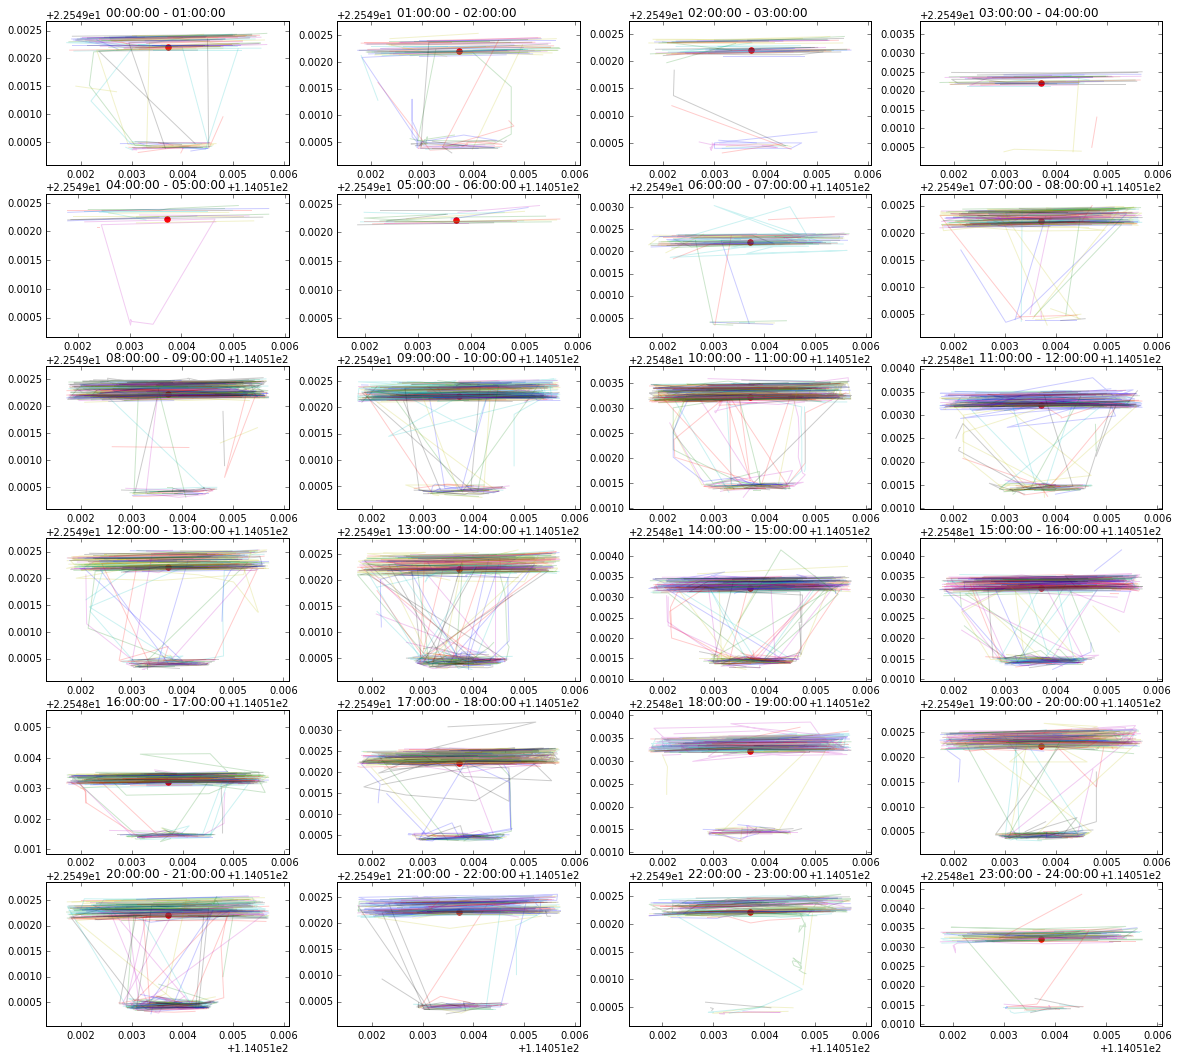

In [26]:
fig = plt.figure(figsize=(20,18))
for i in xrange(24):
    fig.add_subplot(6,4,i+1)
    plotJR_line(center,
                timeRange(points,pd.Timestamp("%02d:00:00"%i),minutes=0,hours=1),
                alpha=.2)
    plt.title("%02d:00:00 - %02d:00:00 " % (i,i+1))
plt.show()

In [7]:
for i in list(set(rng_res[0])):
    _p = rng_res.ix[rng_res[0]==i,:]

,0,1,2,3
951,22223,2016-04-06 07:35:49,113.890717,22.550667
952,22223,2016-04-06 07:36:04,113.890297,22.550283
953,22223,2016-04-06 07:36:19,113.890297,22.550283
954,22223,2016-04-06 07:36:34,113.890297,22.550283
955,22223,2016-04-06 07:36:49,113.890320,22.550301
956,22223,2016-04-06 07:37:04,113.889732,22.549816
957,22223,2016-04-06 10:16:51,113.889099,22.549101
958,22223,2016-04-06 10:17:06,113.889931,22.549833
959,22223,2016-04-06 10:17:21,113.889984,22.549883
960,22223,2016-04-06 10:17:36,113.889969,22.549883


          0                   1           2          3
5795  60919 2016-04-05 12:02:52  113.800247  22.704033
5796  60919 2016-04-05 12:03:12  113.800133  22.703934
5797  60919 2016-04-05 12:03:32  113.799263  22.704666


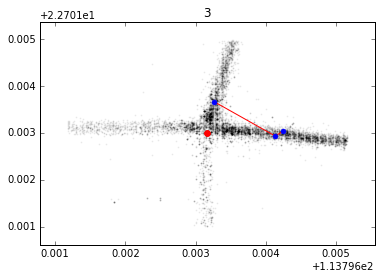

          0                   1           2          3
7392  64095 2016-04-05 12:03:49  113.800964  22.703934
7393  64095 2016-04-05 12:04:10  113.800201  22.704050
9158  64095 2016-04-05 12:04:29  113.798851  22.704216


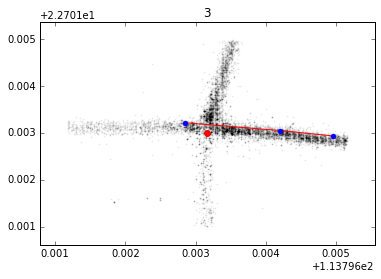

          0                   1           2          3
4147  55556 2016-04-05 12:01:15  113.800667  22.703896
501   55556 2016-04-05 12:01:22  113.799393  22.705492
4148  55556 2016-04-05 12:01:27  113.799339  22.704102
4149  55556 2016-04-05 12:01:28  113.799675  22.704048
4150  55556 2016-04-05 12:01:35  113.799309  22.704920
8544  55556 2016-04-05 12:02:24  113.797829  22.704073
8542  55556 2016-04-05 12:02:24  113.798798  22.704067
8543  55556 2016-04-05 12:02:24  113.798904  22.704056
8545  55556 2016-04-05 12:02:42  113.797546  22.704191
4151  55556 2016-04-05 12:03:22  113.799866  22.704132
4152  55556 2016-04-05 12:03:28  113.800049  22.703941
4153  55556 2016-04-05 12:03:28  113.799377  22.704041
4154  55556 2016-04-05 12:03:33  113.799271  22.704382
4155  55556 2016-04-05 12:03:40  113.799271  22.704712
4156  55556 2016-04-05 12:03:59  113.800629  22.703941
8546  55556 2016-04-05 12:04:45  113.798485  22.704142
4157  55556 2016-04-05 12:04:45  113.799271  22.704084
8547  5555

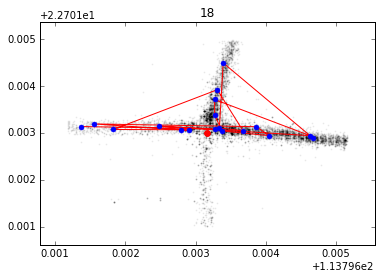

          0                   1           2        3
8305  35214 2016-04-05 12:03:07  113.798698  22.7041
3257  35214 2016-04-05 12:03:37  113.799797  22.7040


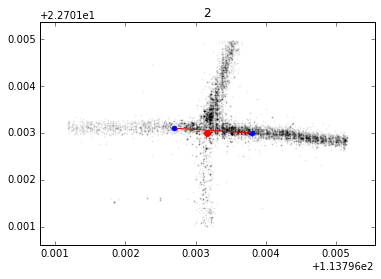

          0                   1           2          3
7621  64192 2016-04-05 12:01:07  113.800301  22.704016
7622  64192 2016-04-05 12:01:28  113.799583  22.704117
7623  64192 2016-04-05 12:01:47  113.799568  22.704100
9265  64192 2016-04-05 12:02:07  113.798180  22.704233


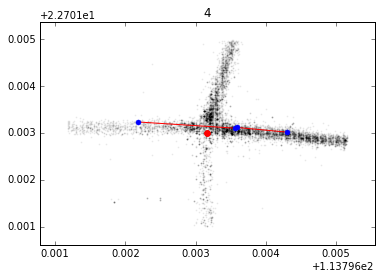

          0                   1           2          3
5881  61295 2016-04-05 12:00:09  113.799057  22.704308
5882  61295 2016-04-05 12:00:39  113.799072  22.704325
5883  61295 2016-04-05 12:00:48  113.799255  22.704052
5884  61295 2016-04-05 12:01:26  113.800644  22.703924


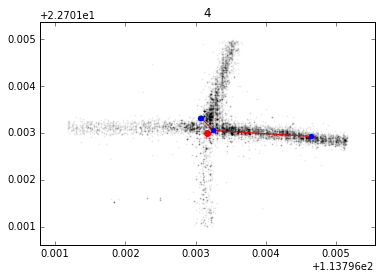

          0                   1           2          3
7354  64083 2016-04-05 12:00:07  113.799049  22.704050
7355  64083 2016-04-05 12:00:27  113.799934  22.703983
7356  64083 2016-04-05 12:00:48  113.800636  22.703884


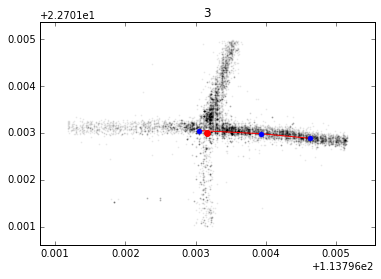

          0                   1           2          3
1731  25218 2016-04-05 12:03:17  113.799232  22.704733
1732  25218 2016-04-05 12:03:18  113.799232  22.704733
1733  25218 2016-04-05 12:03:19  113.799232  22.704733
1734  25218 2016-04-05 12:03:20  113.799232  22.704733


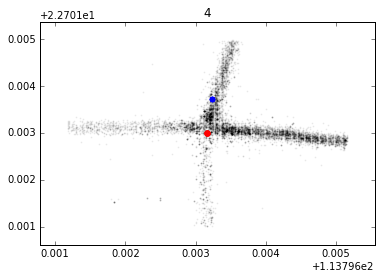

In [26]:
rng_res = timeRange(points,pd.Timestamp("12:00:00"),minutes=5,hours=0).sort_values(1)
for i in list(set(rng_res[0])):
    _p = rng_res.ix[rng_res[0]==i,:]
    print _p
    plotJR_line(center,_p,marker=".",ms=10,mec="b",mfc="b",color="r")
    plotJR(center,points,color="k",s=1,alpha=.05)
    plt.title("%d"%len(_p))
    plt.show()